## Tutorial

this is a python tutorial which ...


In [11]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

from monolib.acoustics import (
    early_to_late_index,
    early_to_total_index,
    edc,
    reverb_time,
)
from monolib.array_ops import normalize
from monolib.containers import Mono, collect, mono
from monolib.mono_utils import mono_lift
from monolib.pipe import PipelineDict

Define some typical type of measurement parameters as well as some labeled sources and receiver locations.

In [12]:
rng = np.random.default_rng(42)
fs = 48_000


sources: dict[str, tuple[float, float, float]] = {
    "S1: Corner": (0.0, 0.0, 0.0),
    "S2: Listener": (0.5, 0.5, 0.5),
}

receivers: dict[str, tuple[float, float, float]] = {
    "R1": (0.1, 0.2, 0.3),
    "R2": (0.6, 0.7, 0.5),
    "R3": (0.4, 0.2, 0.2),
    "R4": (0.1, 0.5, 0.7),
    "R5": (0.4, 0.5, 1.5),
}


Let us generate some fake data representing room impulse responses, and wrap
them into `Mono` objects using the `mono` helper function.

In [ ]:
from monolib.visualize import display_mono


def generate_rir(length=fs * 8, rt60=0.6):
    t = np.arange(length) / fs

    # amplitude decay consistent with RT60 definition
    decay = np.exp(-6.91 * t / rt60)

    rir = decay * rng.standard_normal(length)

    return rir


# make decaying signals
signals = []
for (src_id, src_loc), (rec_id, rec_loc) in product(sources.items(), receivers.items()):
    rt60 = rng.uniform(0.3, 1.1)
    rir = generate_rir(rt60=rt60)

    # append metadata to each thing
    signals.append(
        mono(
            rir,
            sample_rate=fs,
            tags={
                "rt60_true": rt60,
                "source_id": src_id,
                "source_loc": src_loc,
                "receiver_id": rec_id,
                "receiver_loc": rec_loc,
                "do_amplification": np.random.choice([True, False]),
                "duration (sec)": len(rir) / fs,
            },
        )
    )

# inspect one signalj
display_mono(signals[0])

Mono
├── data: array([ 1.00000551e+00,  7.50201669e-01,  9.40180452e-01, ...,
│          -1.03291464e-04, -1.11695937e-05,  1.87634667e-04], shape=(384000,))
├── sample_rate: 48000
└── tags
    ├── rt60_true: 0.9191648388447706
    ├── source_id: S1: Corner
    ├── source_loc: (0.0, 0.0, 0.0)
    ├── receiver_id: R1
    ├── receiver_loc: (0.1, 0.2, 0.3)
    ├── do_amplification: True
    └── duration (sec): 8.0

We can inspect the signal by plotting it like so,

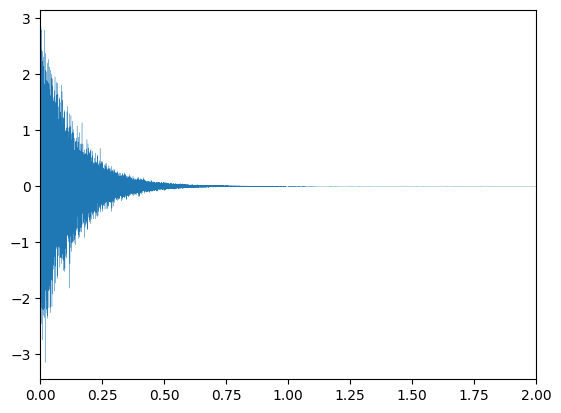

In [14]:
from monolib.mono_utils import time

plt.plot(time(signals[0]), signals[0].data, linewidth=0.2)
plt.xlim(0, 2)
plt.show()

In [15]:
from monolib.visualize import visualize_mono_collection

collection = collect(*signals, tags={"timestamp": "today", "title": "Untitled"})

# bug should inherit collection tags
visualize_mono_collection(collection)

MonoCollection
├── collection tags
│   ├── timestamp: today
│   └── title: Untitled
└── entries (10)
    ├── Mono Entry 0
    │   ├── data: array([ 1.00000551e+00,  7.50201669e-01,  9.40180452e-01, ...,
    │   │          -1.03291464e-04, -1.11695937e-05,  1.87634667e-04], shape=(384000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 0.9191648388447706
    │       ├── source_id: S1: Corner
    │       ├── source_loc: (0.0, 0.0, 0.0)
    │       ├── receiver_id: R1
    │       ├── receiver_loc: (0.1, 0.2, 0.3)
    │       ├── do_amplification: True
    │       └── duration (sec): 8.0
    ├── Mono Entry 1
    │   ├── data: array([ 1.00005528e+00, -2.09298544e+00,  1.15862326e+00, ...,
    │   │          -6.31418708e-05, -3.74306106e-05, -1.02940989e-04], shape=(384000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 0.3968192965134909
    │       ├── source_id: S1: Corner
    │       ├── source_loc: (0.0, 0.0, 0.0)
    │       ├── receiver_id: R2
    │       ├── receiver_loc: (0.6, 0.7, 0.5)
    │       ├── do_amplification: True
    │       └── duration (sec): 8.0
    ├── Mono Entry 2
    │   ├── data: array([ 9.99870707e-01,  1.36611180e+00,  1.68044900e+00, ...,
    │   │          -1.66016311e-04,  2.74292582e-05,  3.29744954e-05], shape=(384000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 0.5530633008634056
    │       ├── source_id: S1: Corner
    │       ├── source_loc: (0.0, 0.0, 0.0)
    │       ├── receiver_id: R3
    │       ├── receiver_loc: (0.4, 0.2, 0.2)
    │       ├── do_amplification: False
    │       └── duration (sec): 8.0
    ├── Mono Entry 3
    │   ├── data: array([ 1.00017241e+00, -1.27367500e+00,  1.19224123e-01, ...,
    │   │          -5.03445119e-05, -1.96851027e-05, -2.29232933e-04], shape=(384000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 0.5832891979555423
    │       ├── source_id: S1: Corner
    │       ├── source_loc: (0.0, 0.0, 0.0)
    │       ├── receiver_id: R4
    │       ├── receiver_loc: (0.1, 0.5, 0.7)
    │       ├── do_amplification: True
    │       └── duration (sec): 8.0
    ├── Mono Entry 4
    │   ├── data: array([ 1.00001274e+00,  9.21483241e-01, -1.69560270e+00, ...,
    │   │          -8.71006529e-05, -1.49282068e-04,  9.26026469e-06], shape=(384000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 1.0267715469224947
    │       ├── source_id: S1: Corner
    │       ├── source_loc: (0.0, 0.0, 0.0)
    │       ├── receiver_id: R5
    │       ├── receiver_loc: (0.4, 0.5, 1.5)
    │       ├── do_amplification: False
    │       └── duration (sec): 8.0
    ├── Mono Entry 5
    │   ├── data: array([ 9.99818455e-01, -1.20810548e-01, -1.27846597e-01, ...,
    │   │          -6.55489201e-05, -1.16413741e-04,  1.69646461e-05], shape=(384000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 0.886886306448567
    │       ├── source_id: S2: Listener
    │       ├── source_loc: (0.5, 0.5, 0.5)
    │       ├── receiver_id: R1
    │       ├── receiver_loc: (0.1, 0.2, 0.3)
    │       ├── do_amplification: True
    │       └── duration (sec): 8.0
    ├── Mono Entry 6
    │   ├── data: array([ 1.00001131e+00,  8.43890528e-01, -1.14176396e+00, ...,
    │   │           1.80480726e-05,  5.36583786e-05,  7.28421765e-05], shape=(384000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 0.8488170558930515
    │       ├── source_id: S2: Listener
    │       ├── source_loc: (0.5, 0.5, 0.5)
    │       ├── receiver_id: R2
    │       ├── receiver_loc: (0.6, 0.7, 0.5)
    │       ├── do_amplification: True
    │       └── duration (sec): 8.0
    ├── Mono Entry 7
    │   ├── data: array([ 1.00005287e+00, -6.53722916e-01, -8.24826116e-01, ...,
    │   │           5.69360929e-05, -1.53499669e-04, -2.86559936e-04], shape=(384000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_tr

Lets create a processing pipeline via `PipelineDict`

In [16]:
from scipy.signal import sosfiltfilt, butter


def zero_pad(m: Mono):
    zero_duration = 10e-3
    zeros = np.zeros(int(m.sample_rate * zero_duration))
    return np.concatenate([zeros, m.data])


def truncate(m: Mono):
    # access via unpacking
    x, sample_rate, _ = m
    trunc_sec = 1
    return x[: sample_rate * trunc_sec]


def amplify(m: Mono):
    x, _, tags = m
    if tags["do_amplification"]:
        return 2 * x
    return x


def filter_below_100(m: Mono):
    x, sample_rate, _ = m
    sos = butter(4, 100, "high", output="sos", fs=sample_rate)
    x = sosfiltfilt(sos, x)
    return x


def filter_above_10k(m: Mono):
    x, sample_rate, _ = m
    sos = butter(4, 10e3, "low", output="sos", fs=sample_rate)
    x = sosfiltfilt(sos, x)
    return x


# lift array function to operate on mono inputs
normalize_func = mono_lift(normalize)

# define a preprocessing pipeline. This will sequentially process
# the signals in `collection` and return an updated collection
pipeline = PipelineDict(
    {
        "normalize": normalize_func,
        "zero_pad": zero_pad,
        "truncate": truncate,
        "filter_below_100": filter_below_100,
        "filter_above_10k": filter_above_10k,
    }
)

# Process collection via pipeline and visualize progress
collection, scoped = pipeline(collection, progress_meter=True, has_scope=True)


# Update the duration field
collection = collection.map_tags(
    lambda x: {
        "duration (sec)": len(x.data) / x.sample_rate,
    }
)

visualize_mono_collection(collection)


doing work...: 100%|██████████| 5/5 [00:00<00:00, 41.56step/s]


MonoCollection
├── collection tags
│   ├── timestamp: today
│   └── title: Untitled
└── entries (10)
    ├── Mono Entry 0
    │   ├── data: array([ 5.87993738e-04,  5.90572213e-04,  5.93096129e-04, ...,
    │   │           1.90988412e-05,  2.17402278e-05, -3.50626894e-05], shape=(48000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 0.9191648388447706
    │       ├── source_id: S1: Corner
    │       ├── source_loc: (0.0, 0.0, 0.0)
    │       ├── receiver_id: R1
    │       ├── receiver_loc: (0.1, 0.2, 0.3)
    │       ├── do_amplification: True
    │       └── duration (sec): 1.0
    ├── Mono Entry 1
    │   ├── data: array([2.81180948e-04, 2.82004096e-04, 2.82797896e-04, ...,
    │   │          4.98181973e-05, 4.19170531e-05, 1.50339943e-05], shape=(48000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 0.3968192965134909
    │       ├── source_id: S1: Corner
    │       ├── source_loc: (0.0, 0.0, 0.0)
    │       ├── receiver_id: R2
    │       ├── receiver_loc: (0.6, 0.7, 0.5)
    │       ├── do_amplification: True
    │       └── duration (sec): 1.0
    ├── Mono Entry 2
    │   ├── data: array([ 1.85427950e-04,  1.96596851e-04,  2.07828254e-04, ...,
    │   │          -3.65657992e-08, -8.49719389e-06,  4.21245669e-06], shape=(48000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 0.5530633008634056
    │       ├── source_id: S1: Corner
    │       ├── source_loc: (0.0, 0.0, 0.0)
    │       ├── receiver_id: R3
    │       ├── receiver_loc: (0.4, 0.2, 0.2)
    │       ├── do_amplification: False
    │       └── duration (sec): 1.0
    ├── Mono Entry 3
    │   ├── data: array([3.86047803e-05, 2.95828231e-05, 2.04864522e-05, ...,
    │   │          6.03726351e-05, 4.08253219e-05, 1.31745946e-05], shape=(48000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 0.5832891979555423
    │       ├── source_id: S1: Corner
    │       ├── source_loc: (0.0, 0.0, 0.0)
    │       ├── receiver_id: R4
    │       ├── receiver_loc: (0.1, 0.5, 0.7)
    │       ├── do_amplification: True
    │       └── duration (sec): 1.0
    ├── Mono Entry 4
    │   ├── data: array([-0.00076409, -0.00075936, -0.00075449, ...,  0.00038565,
    │   │           0.00038082,  0.00011973], shape=(48000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 1.0267715469224947
    │       ├── source_id: S1: Corner
    │       ├── source_loc: (0.0, 0.0, 0.0)
    │       ├── receiver_id: R5
    │       ├── receiver_loc: (0.4, 0.5, 1.5)
    │       ├── do_amplification: False
    │       └── duration (sec): 1.0
    ├── Mono Entry 5
    │   ├── data: array([-8.41506730e-06, -2.40513046e-05, -3.98062824e-05, ...,
    │   │           1.50331721e-04,  1.20854310e-04,  1.10726061e-04], shape=(48000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 0.886886306448567
    │       ├── source_id: S2: Listener
    │       ├── source_loc: (0.5, 0.5, 0.5)
    │       ├── receiver_id: R1
    │       ├── receiver_loc: (0.1, 0.2, 0.3)
    │       ├── do_amplification: True
    │       └── duration (sec): 1.0
    ├── Mono Entry 6
    │   ├── data: array([0.00028346, 0.00028427, 0.00028504, ..., 0.00015986, 0.00013653,
    │   │          0.00010486], shape=(48000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 0.8488170558930515
    │       ├── source_id: S2: Listener
    │       ├── source_loc: (0.5, 0.5, 0.5)
    │       ├── receiver_id: R2
    │       ├── receiver_loc: (0.6, 0.7, 0.5)
    │       ├── do_amplification: True
    │       └── duration (sec): 1.0
    ├── Mono Entry 7
    │   ├── data: array([1.09606626e-04, 1.06059596e-04, 1.02471098e-04, ...,
    │   │          9.57466535e-06, 5.87624900e-06, 1.16885891e-06], shape=(48000,))
    │   ├── sample_rate: 48000
    │   └── tags
    │       ├── rt60_true: 0.5887952135092908
    │       ├── source_id: S2: Listener
    │       ├── s

Let's scope the results

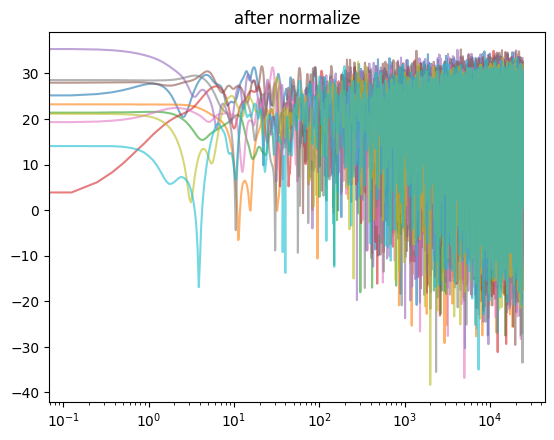

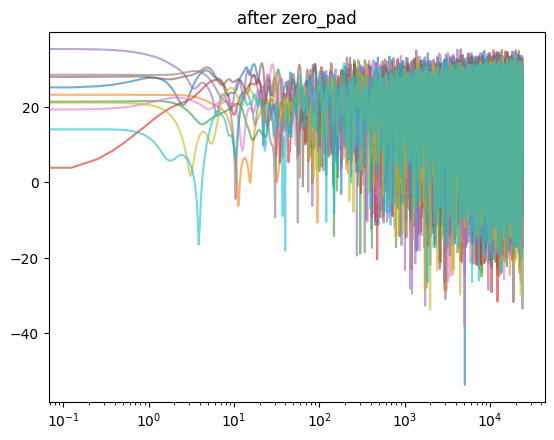

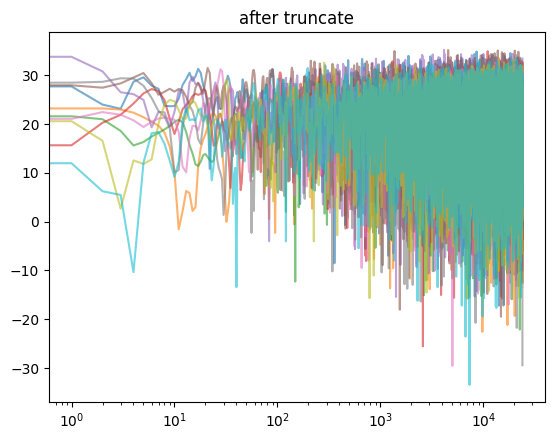

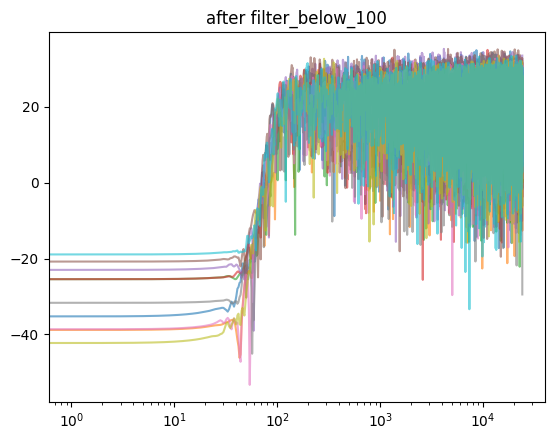

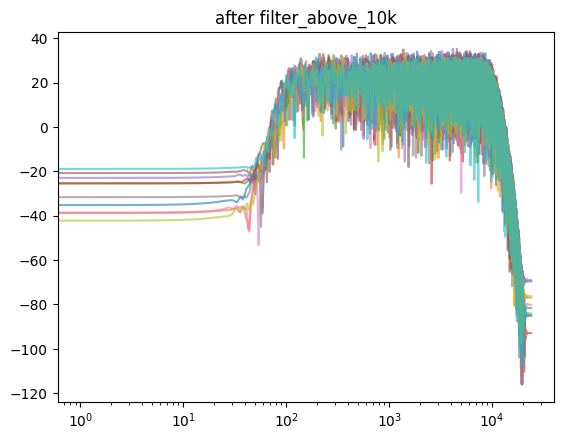

In [17]:
import monolib.mono_utils as mu
from monolib.array_ops import linear_to_db

for step_label, step_collection in scoped.items():
    # let's inspect the first entry in the collection for each step
    for x in step_collection.valid_entries:
        plt.semilogx(
            mu.frequency(x),
            linear_to_db(mu.magnitude_response(x)),
            alpha=0.6,
        )
    plt.title(f"after {step_label}")
    plt.show()

In [18]:
# define a function to extract various stats about our signals
def extract_acoustics(m: Mono):
    e = m.map_data(lambda x: edc(x.data))
    rt60 = reverb_time(collect(e))
    d50 = early_to_total_index(m, 50e-3)
    c80 = early_to_late_index(m, 80e-3)
    return {
        "rt60": rt60,
        "d50": d50,
        "c80": c80,
    }


# Add acoustics parameters as tags to each signal
collection = collection.map_tags(lambda m: extract_acoustics(m))


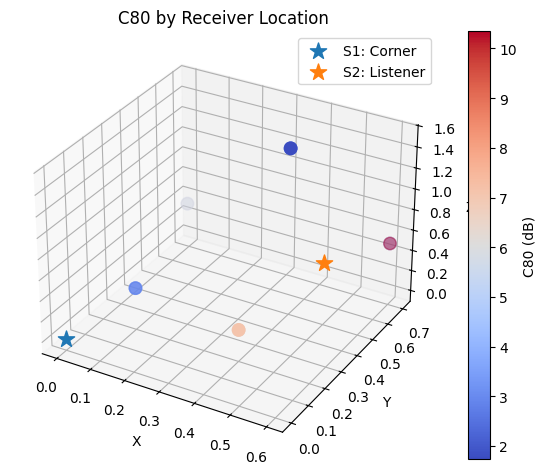

In [19]:
# Collect receiver locations and C80
rec_locs = collection.get_tags("receiver_loc")
c80 = collection.get_tags("c80")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

x, y, z = zip(*rec_locs)
sc = ax.scatter(
    x,
    y,
    z,
    c=c80,
    cmap="coolwarm",
    s=80,
)

# mark sources too
for src_id, src_loc in sources.items():
    ax.scatter(*src_loc, s=150, marker="*", label=src_id)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("C80 by Receiver Location")

plt.colorbar(sc, label="C80 (dB)")
plt.legend()
plt.tight_layout()
plt.show()


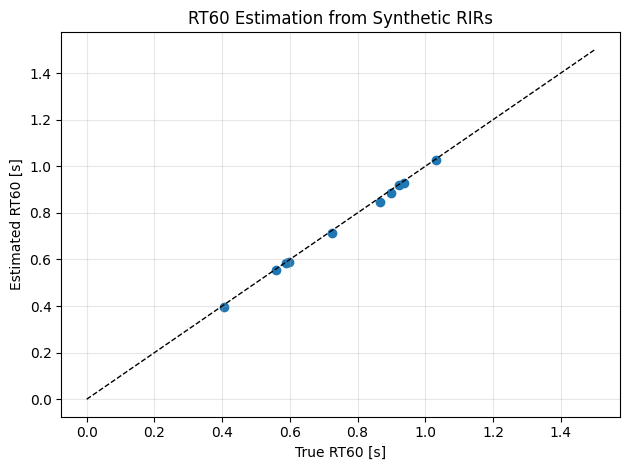

In [20]:
# rt vs truth
fig = plt.figure()
plt.scatter(collection.get_tags("rt60"), collection.get_tags("rt60_true"))
plt.plot([0, 1.5], [0, 1.5], "k--", lw=1)
plt.xlabel("True RT60 [s]")
plt.ylabel("Estimated RT60 [s]")
plt.title("RT60 Estimation from Synthetic RIRs")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
